In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas
import pandas as pd


import tensorflow as tf
import tf_data

In [2]:
import tensorflow as tf
import json, os
import numpy as np

# Tested with TensorFlow 2.1.0
print('version={}, CUDA={}, GPU={}, TPU={}'.format(
    tf.__version__, tf.test.is_built_with_cuda(),
    # GPU attached?
    len(tf.config.list_physical_devices('GPU')) > 0,
    # TPU accessible? (only works on Colab)
    'COLAB_TPU_ADDR' in os.environ))

if len(tf.config.list_physical_devices('GPU')) > 0:
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
    strategy = tf.distribute.OneDeviceStrategy("gpu:0")

version=2.3.0, CUDA=True, GPU=True, TPU=False


# Dataset building

In [5]:
# check max number of samples
df_ele_train = pd.read_csv("/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v8/training/records_metadata.txt", sep=';')
df_ele_test = pd.read_csv("/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v8/testing/records_metadata.txt", sep=';')
df_gamma_train = pd.read_csv("/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v8/training/records_metadata.txt", sep=';')
df_gamma_test = pd.read_csv("/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v8/testing/records_metadata.txt", sep=';')

In [6]:
print( "Ele training: ", df_ele_train[df_ele_train["class"]!=0].n.sum())
print( "Gamma training: ", df_gamma_train[df_gamma_train["class"]!=0].n.sum())
print( "Ele test: ", df_ele_test[df_ele_test["class"]!=0].n.sum())
print( "Gamma test: ", df_gamma_test[df_gamma_test["class"]!=0].n.sum())

print("unmatched training: ",df_ele_train[df_ele_train["class"]==0].n.sum() + df_gamma_train[df_gamma_train["class"]==0].n.sum()  )
print("unmatched testing: ", df_ele_test[df_ele_test["class"]==0].n.sum() + df_gamma_test[df_gamma_test["class"]!=0].n.sum()  )

Ele training:  1434462
Gamma training:  2876024
Ele test:  475617
Gamma test:  478838
unmatched training:  8803679
unmatched testing:  1450785


In [7]:
data_path = {"ele_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v8/training/calo_matched/*.proto",
             #"gamma_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/calo_matched/*.proto",
             #"ele_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v2/training/no_calo_matched/*.proto",
             #"gamma_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/no_calo_matched/*.proto"
            }

In [8]:
features = [ "en_cluster","et_cluster",
            "cluster_eta", "cluster_phi", 
            "cluster_ieta","cluster_iphi","cluster_iz",
            "cluster_deta", "cluster_dphi",
            "cluster_den_seed","cluster_det_seed",
            "cl_f5_r9", "cl_f5_sigmaIetaIeta", "cl_f5_sigmaIetaIphi",
            "cl_f5_sigmaIphiIphi","cl_f5_swissCross",
            "cl_r9", "cl_sigmaIetaIeta", "cl_sigmaIetaIphi",
            "cl_sigmaIphiIphi","cl_swissCross",
            "cl_nxtals", "cl_etaWidth","cl_phiWidth"]

window_features = [  "max_en_cluster","max_et_cluster","max_deta_cluster","max_dphi_cluster","max_den_cluster","max_det_cluster",
                         "min_en_cluster","min_et_cluster","min_deta_cluster","min_dphi_cluster","min_den_cluster","min_det_cluster",
                         "mean_en_cluster","mean_et_cluster","mean_deta_cluster","mean_dphi_cluster","mean_den_cluster","mean_det_cluster" ]

# Metadata about the window like true energy, true calo position, useful info
window_metadata = ["en_true_sim","et_true_sim", "en_true_gen", "et_true_gen",
                    "nclusters_insc",
                    "nVtx", "rho", "obsPU", "truePU",
                    "sim_true_eta", "sim_true_phi",  
                    "en_mustache_raw", "et_mustache_raw","en_mustache_calib", "et_mustache_calib",
                    "event_tot_simen_PU","wtot_simen_PU","wtot_recoen_PU","wtot_simen_sig" ]
    
    

In [9]:
_load_n_items = 10
_batch_size = 6
_nepochs = 1
_ntrain = 10000
_nval = 1000

In [16]:
# Load a balanced dataset from the list of paths given to the function. Selected only the requestes features from clusters and prepare batches
total_ds = tf_data.load_balanced_dataset_batch(data_path, features,window_features, window_metadata,  _batch_size)
# the indexes for energy and et are from the features list we requestes
# total_ds = tf_data.delta_energy_seed(total_ds, en_index=0, et_index=1)
total_ds = tf_data.training_format(total_ds, norm=False) 

In [17]:
X,y = tf_data.get(total_ds)

In [28]:
in_sc, w_flavour, wind_meta = y

In [20]:
cl_X,cl_hits, wind_X, is_seed,n_cl = X

# Graph building layer

In [67]:
from model import *
from plotting import * 

In [68]:
graph = GraphBuilding(output_dim_nodes=32)

In [54]:
rcn = RechitsGCN(nconv=3, input_dim = 4 , output_dim =12)

In [55]:
rechits = cl_hits.to_tensor()
mask_rechits, mask_cls = create_padding_masks(rechits)

In [56]:
output, (sa_output,convout, attention_weights, adj) = rcn(rechits, mask_rechits)

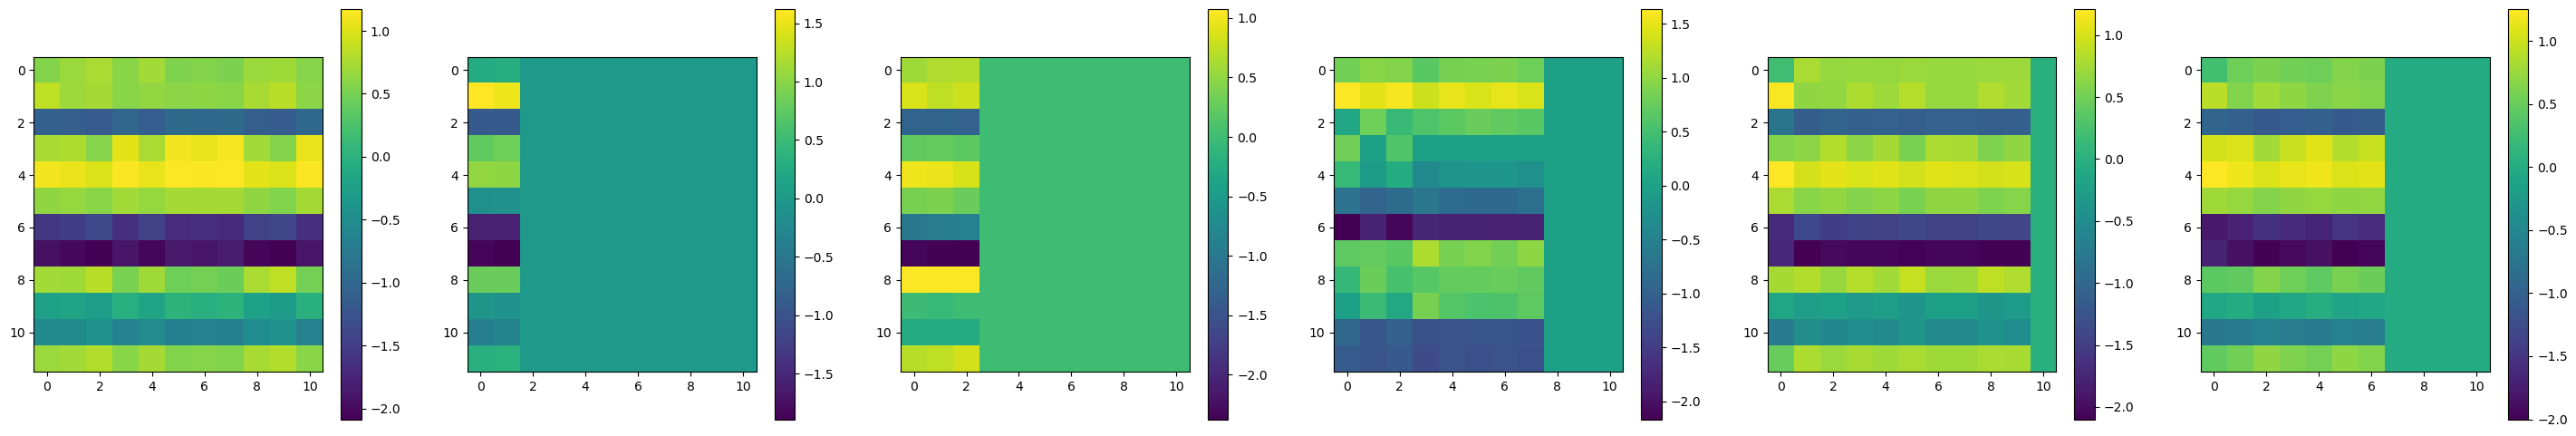

In [58]:
plotM(*output)

In [70]:
cl_x, coord, adj, mask, output_rechits, coord_att_ws = graph(X[0],X[1])

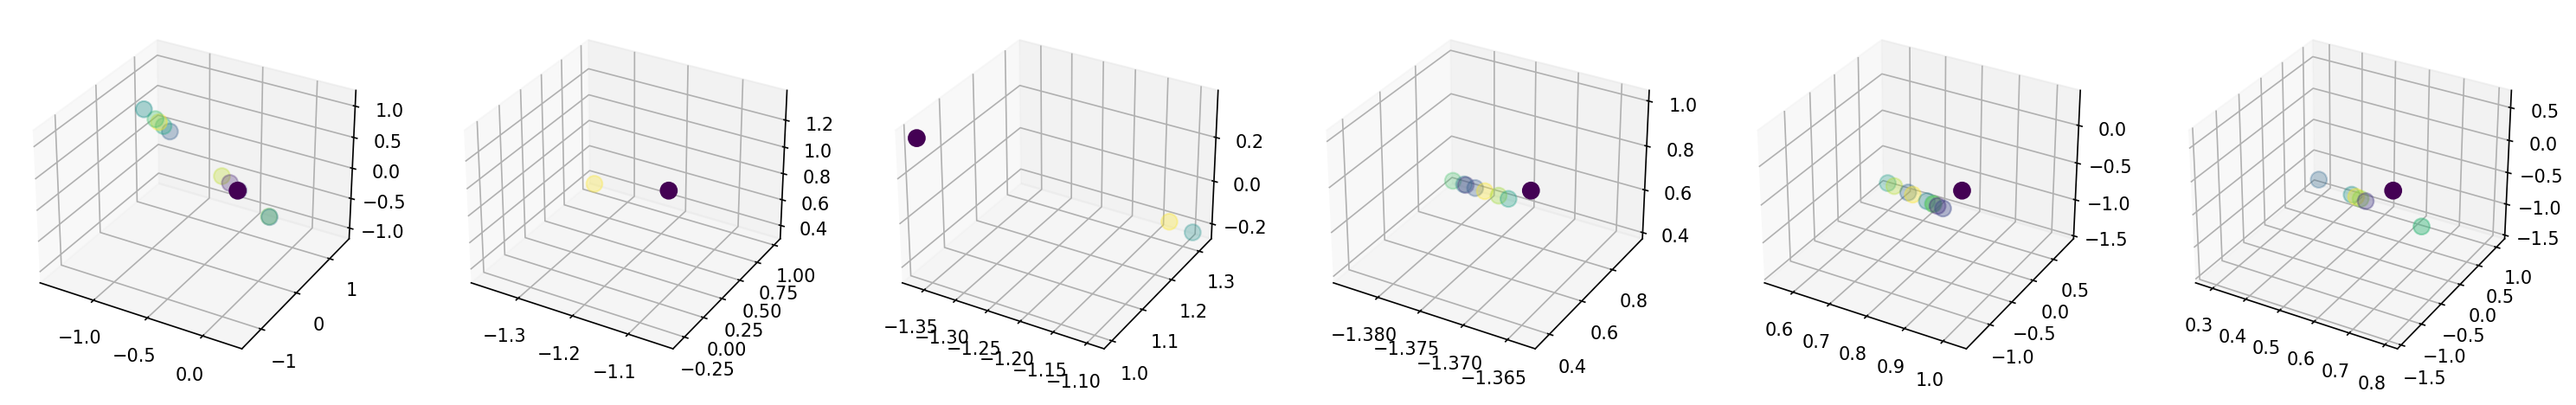

In [71]:
plot3D(coord, mask)

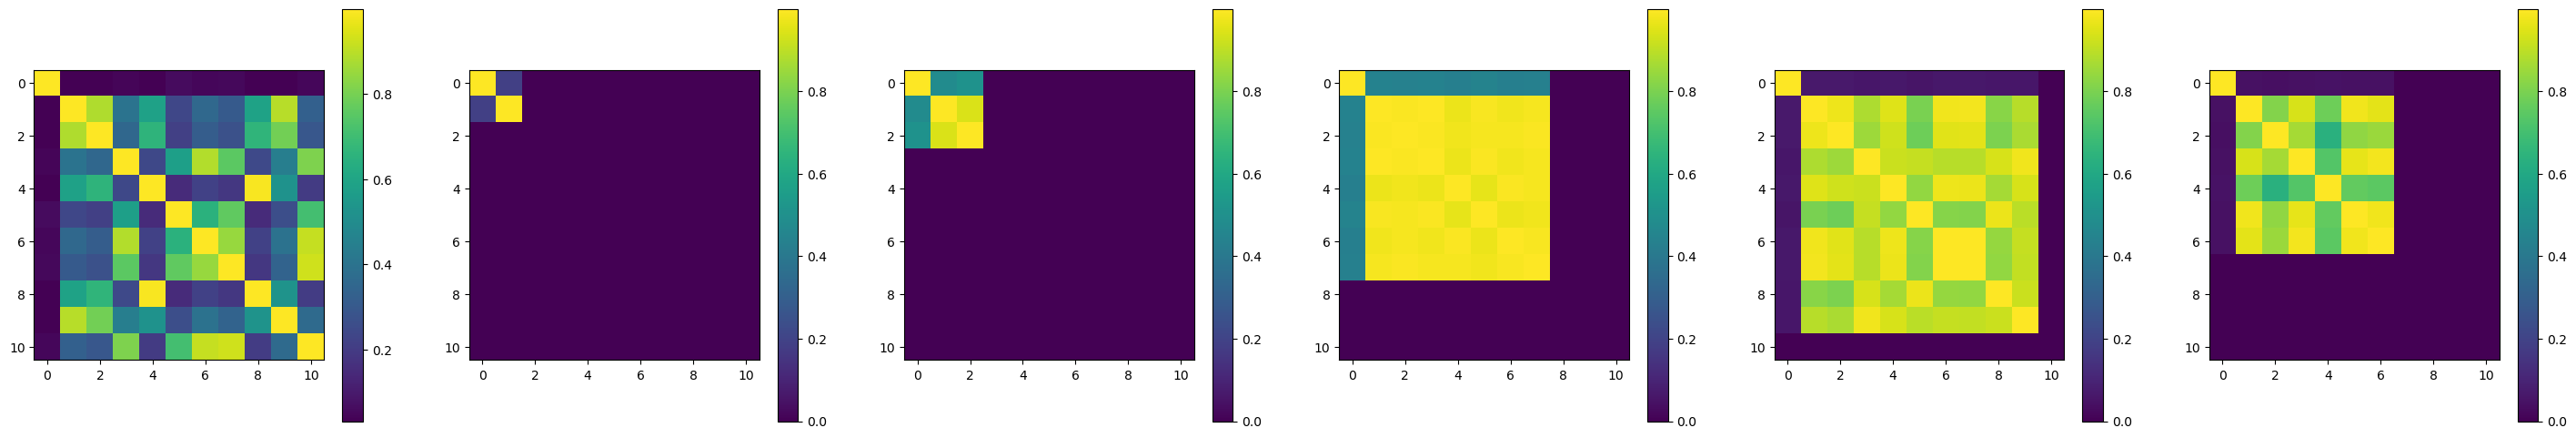

In [72]:
plotM(*adj)

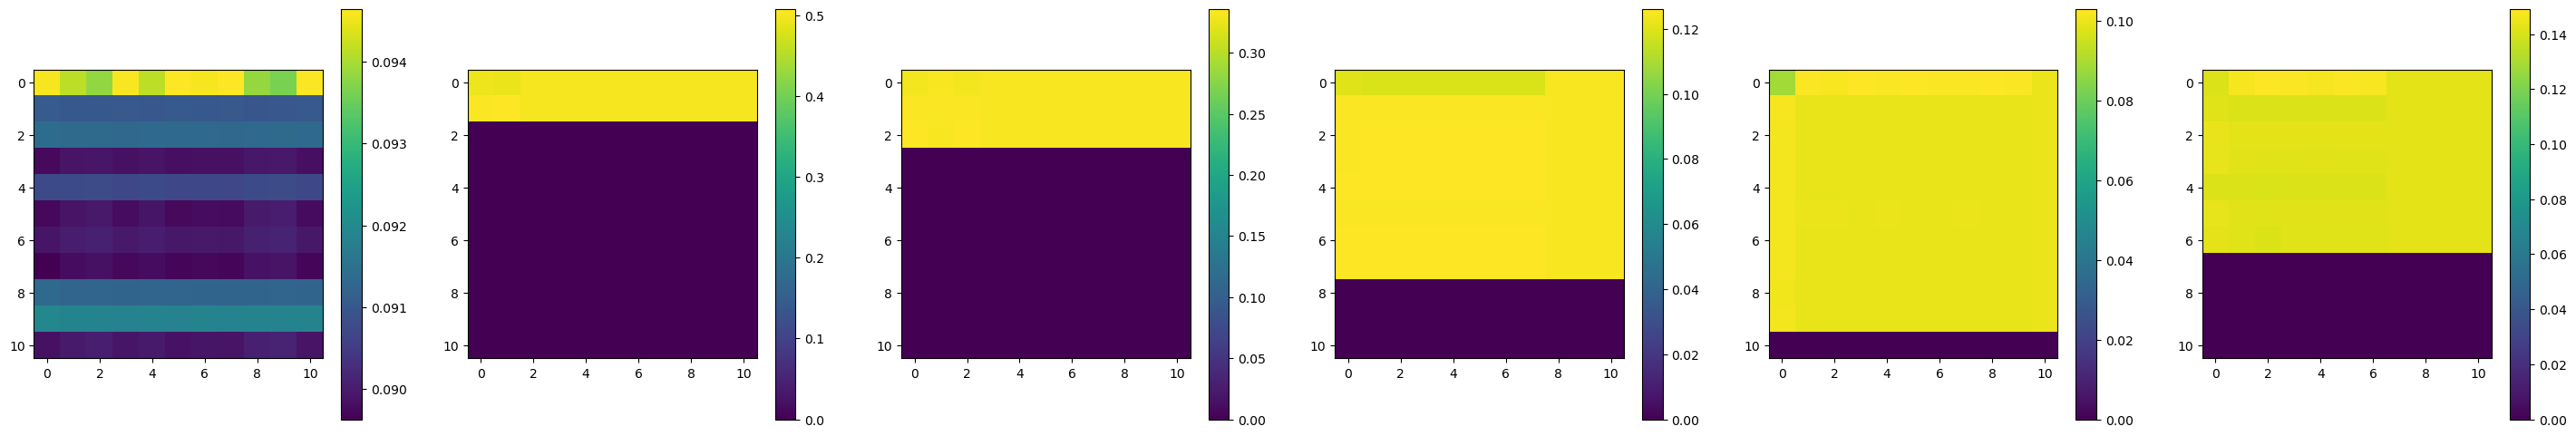

In [75]:
plotM(*coord_att_ws)

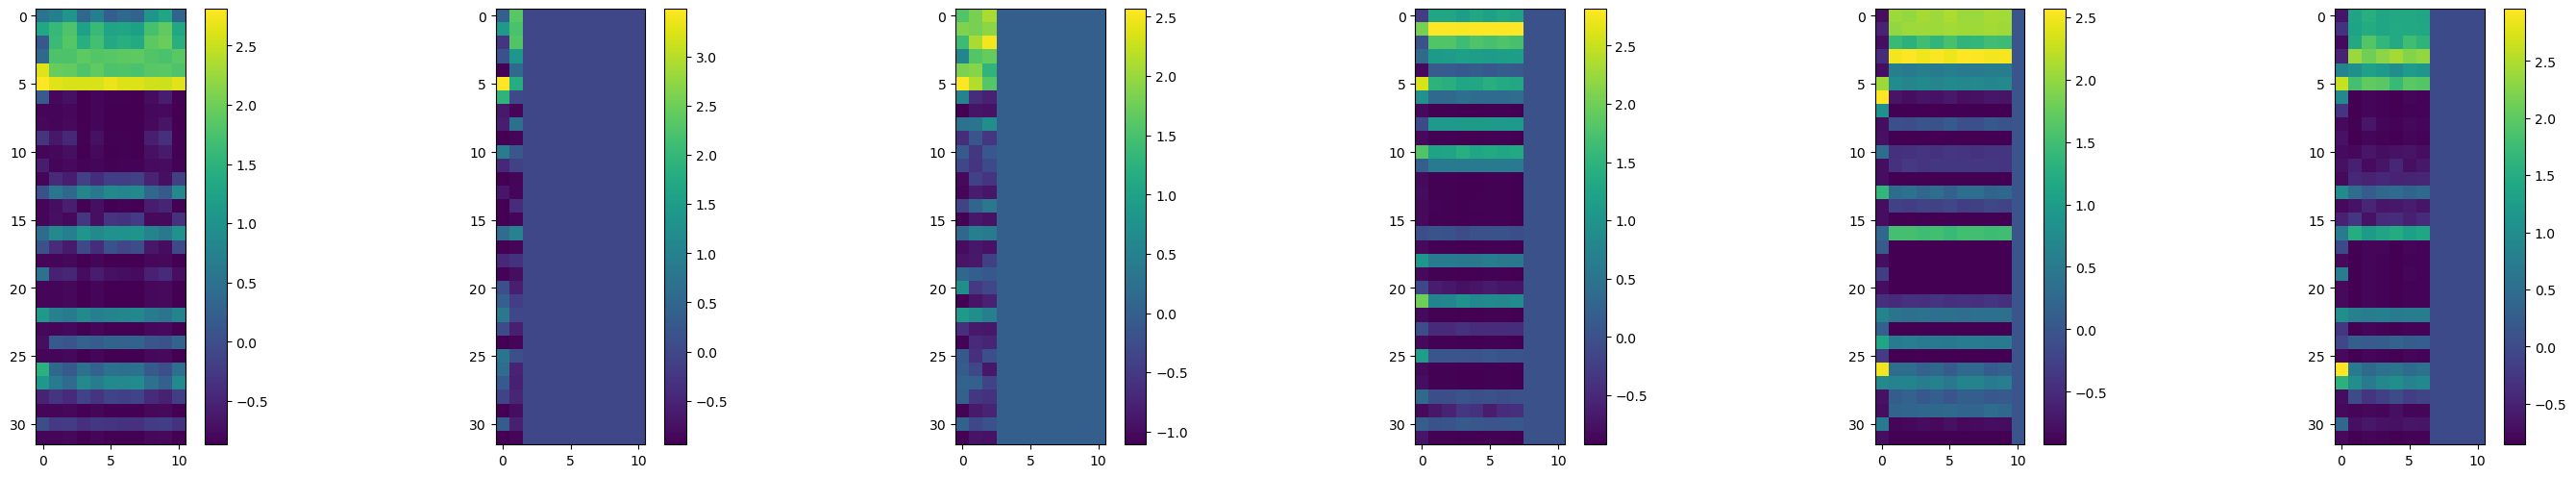

In [93]:
plotM(*cl_x)

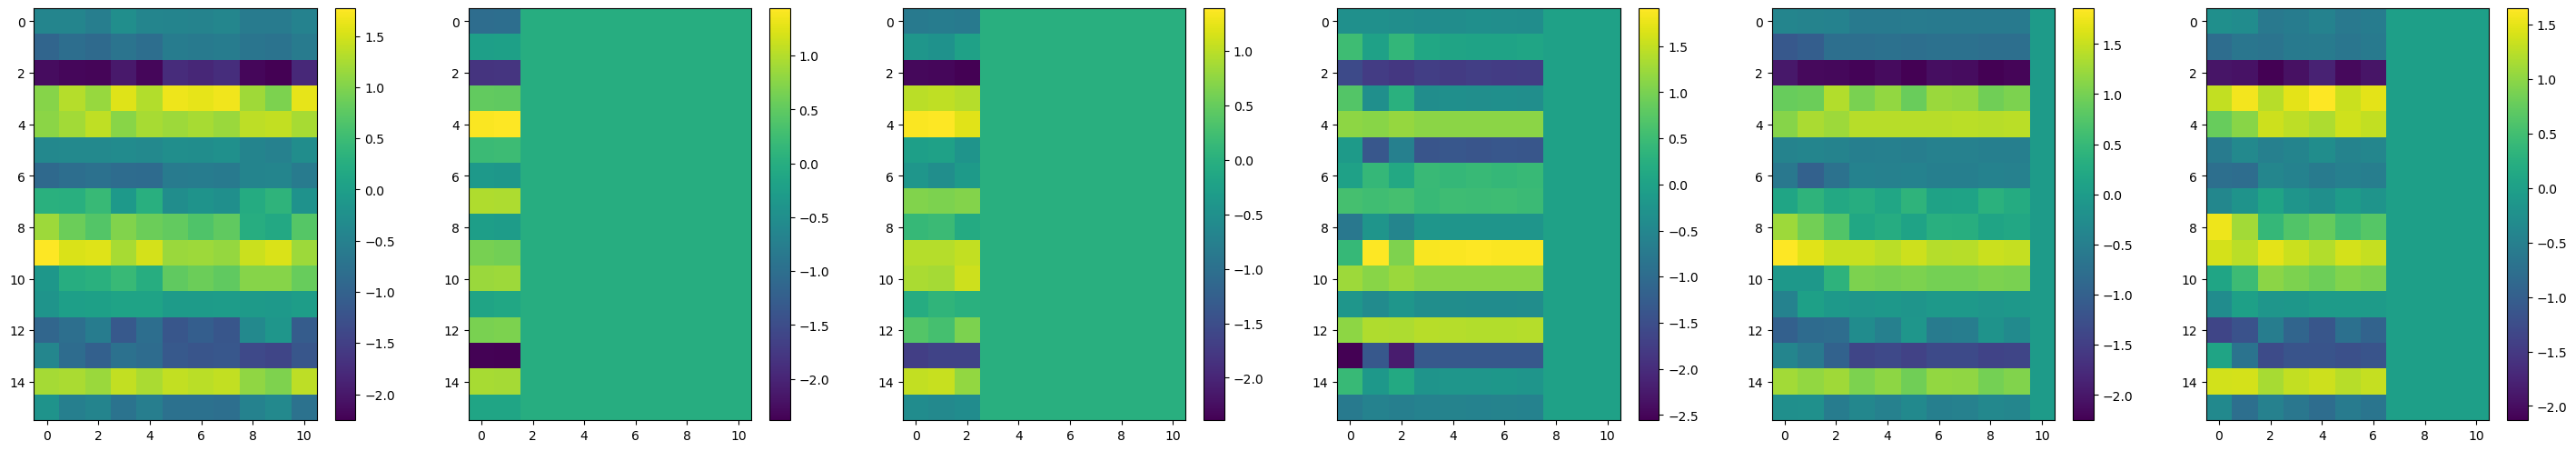

In [74]:
plotM(*output_rechits)

# Complete model

In [80]:
from model import *
from plotting import * 

In [81]:
# output_dim_nodes == latent spoace dimension for the clusters
dcgn = DeepClusterGN(nconv=3, output_dim_nodes=32, layers_input=[64,64,64], layers_coord=[64,64,64,64])

In [27]:
a = model(X)

In [58]:
X, y = tf_data.get(ds_train)

In [74]:
X,y = tf_data.get(ds_test)

In [160]:
X,y = tf_data.get(special_ds)

In [161]:
dense_clclass, windclass, mask_cls, (cl_X, coord, adj, coord_att_ws, output_rechits, out_gcn, out_SAcl ,out_SAw, att_weights_clcall, att_w_windclass) = model(X)

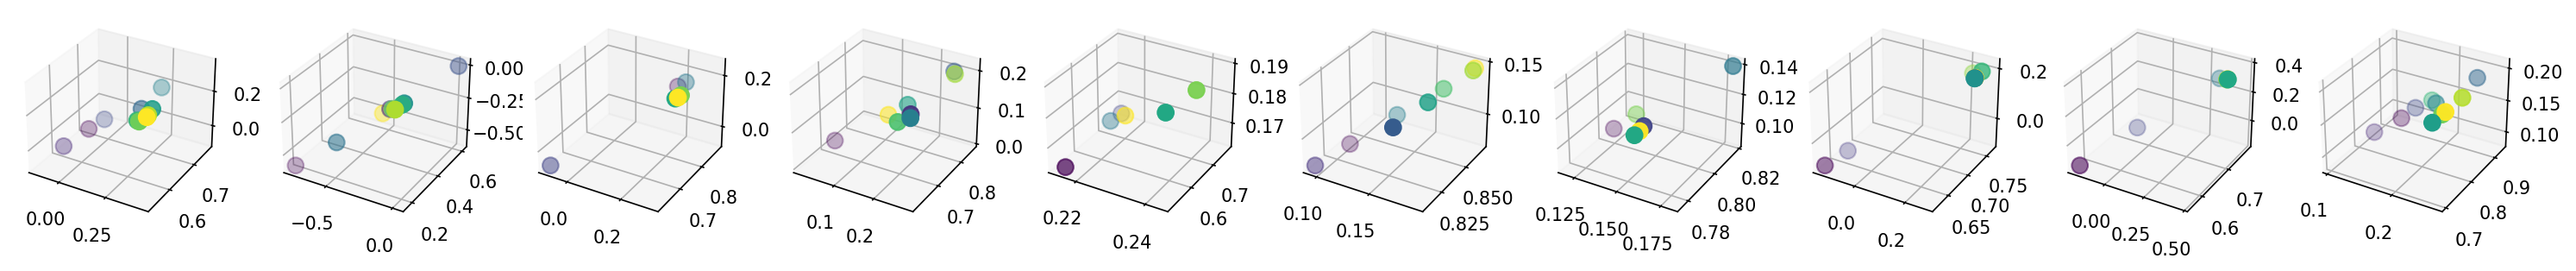

In [162]:
plot3D(coord[0:10], mask_cls)

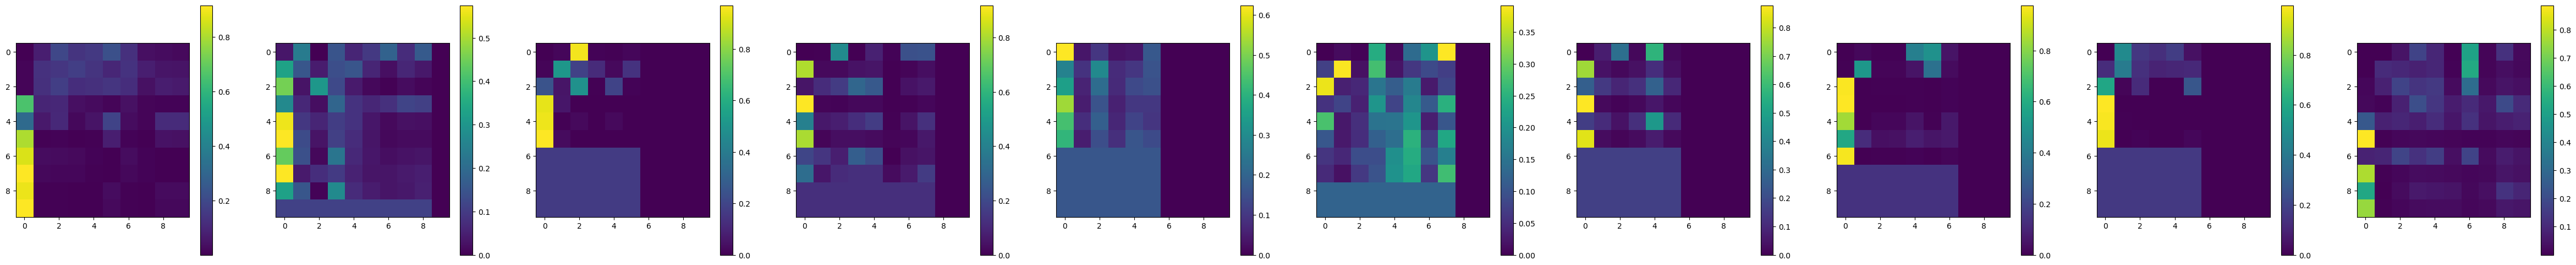

In [163]:
plotM(*coord_att_ws[0:10], t=False)

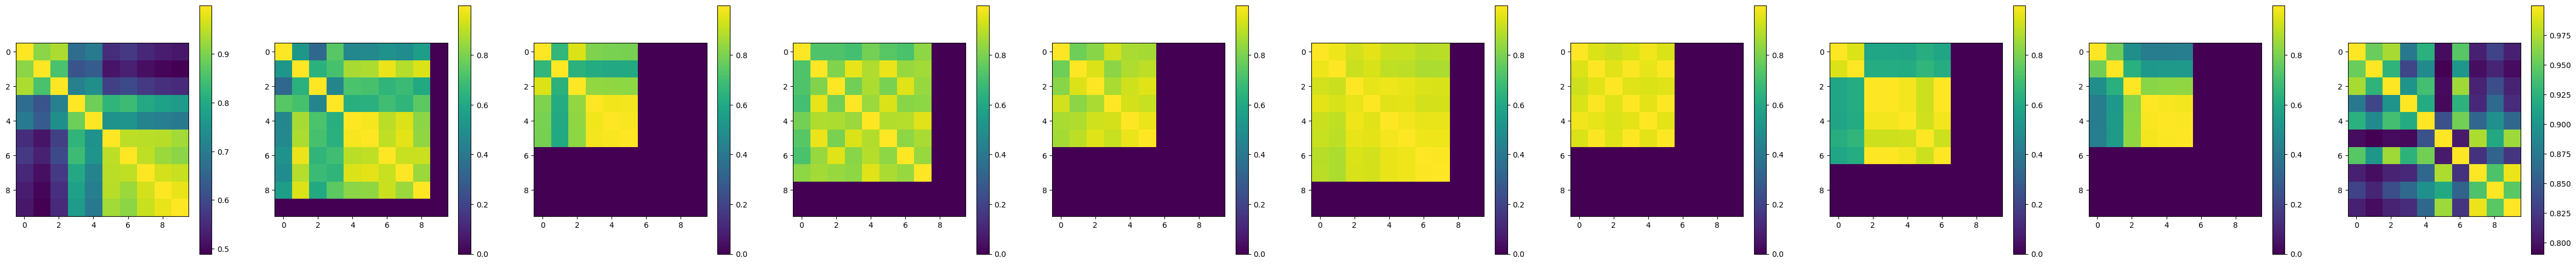

In [164]:
plotM(*adj[0:10])

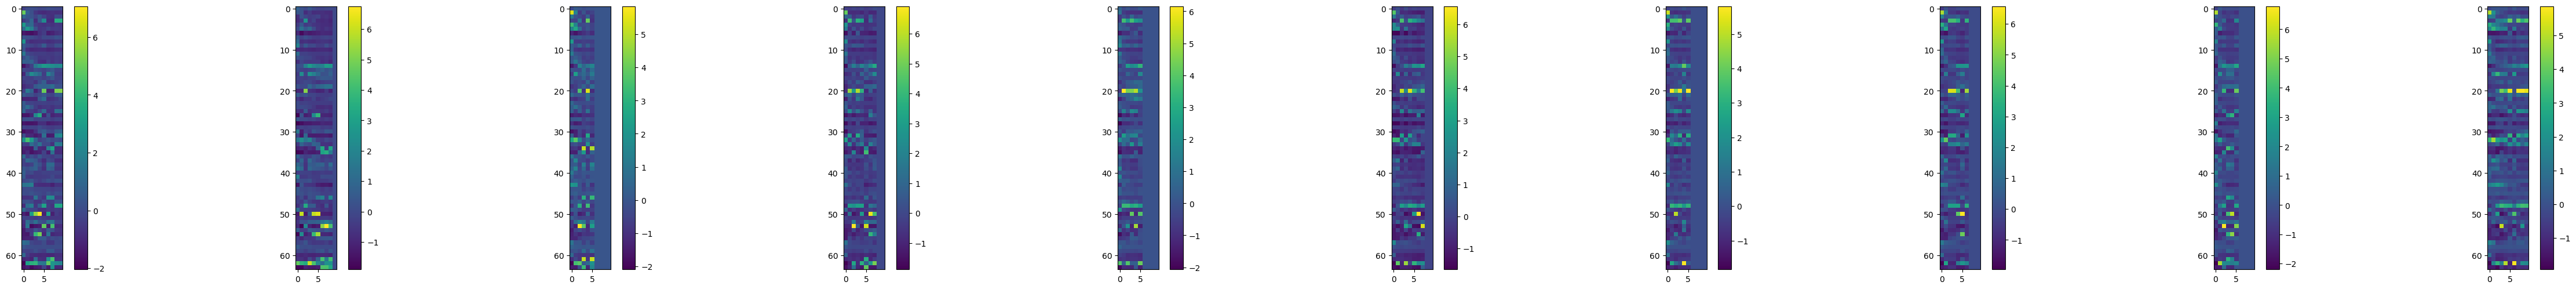

In [165]:
plotM(*cl_X[0:10])

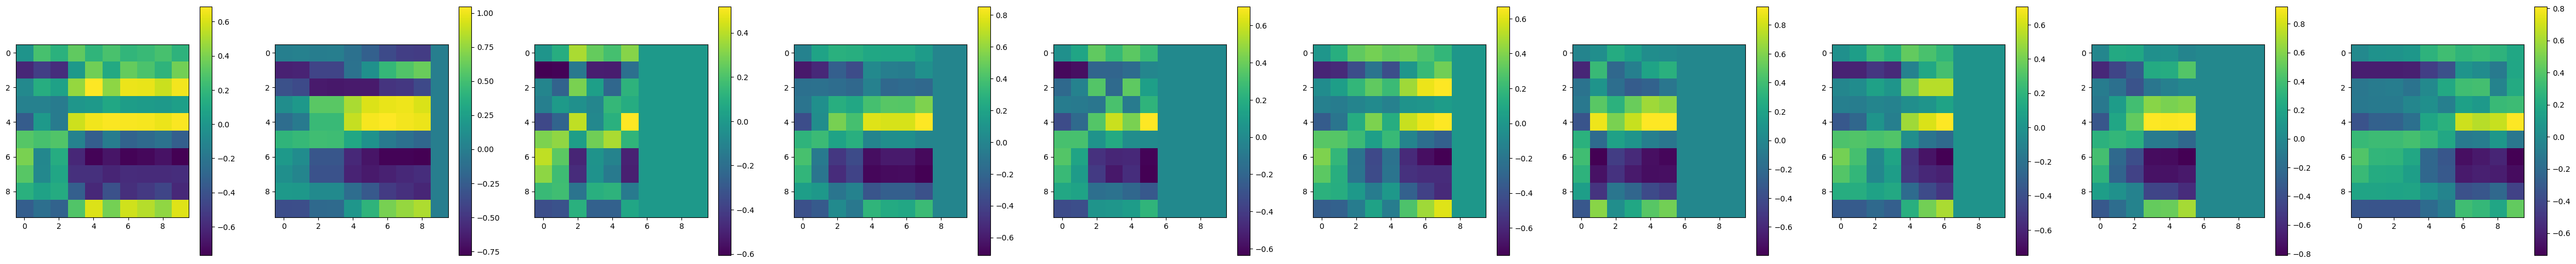

In [166]:
plotM(*output_rechits[0:10])

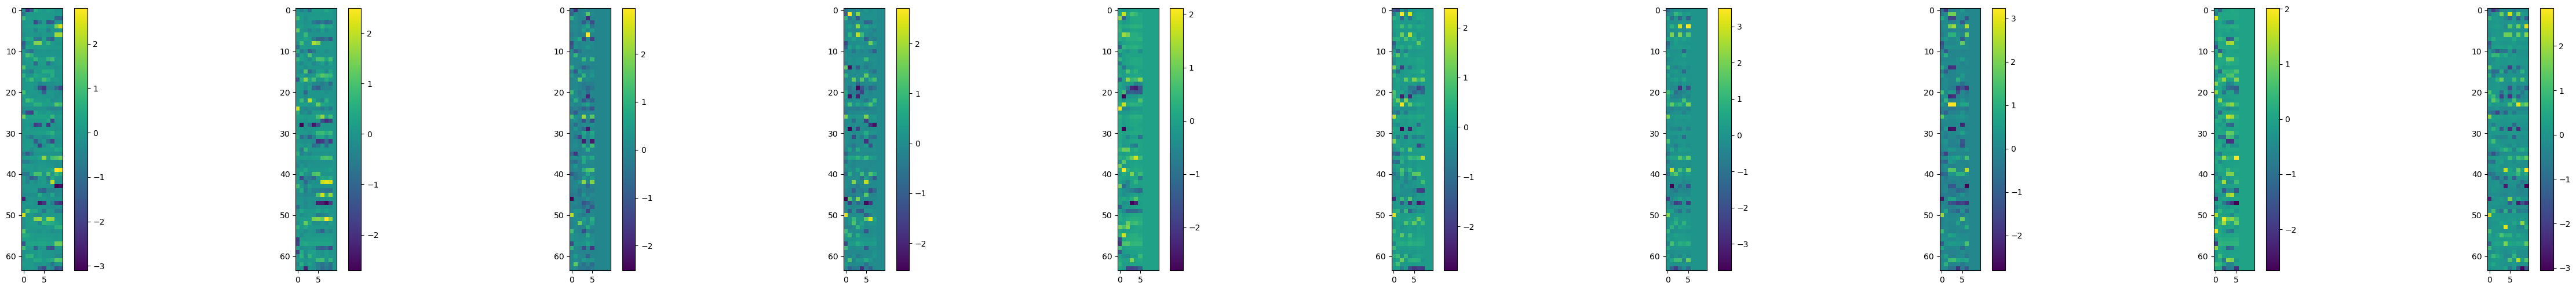

In [167]:
plotM(*out_gcn[0:10])

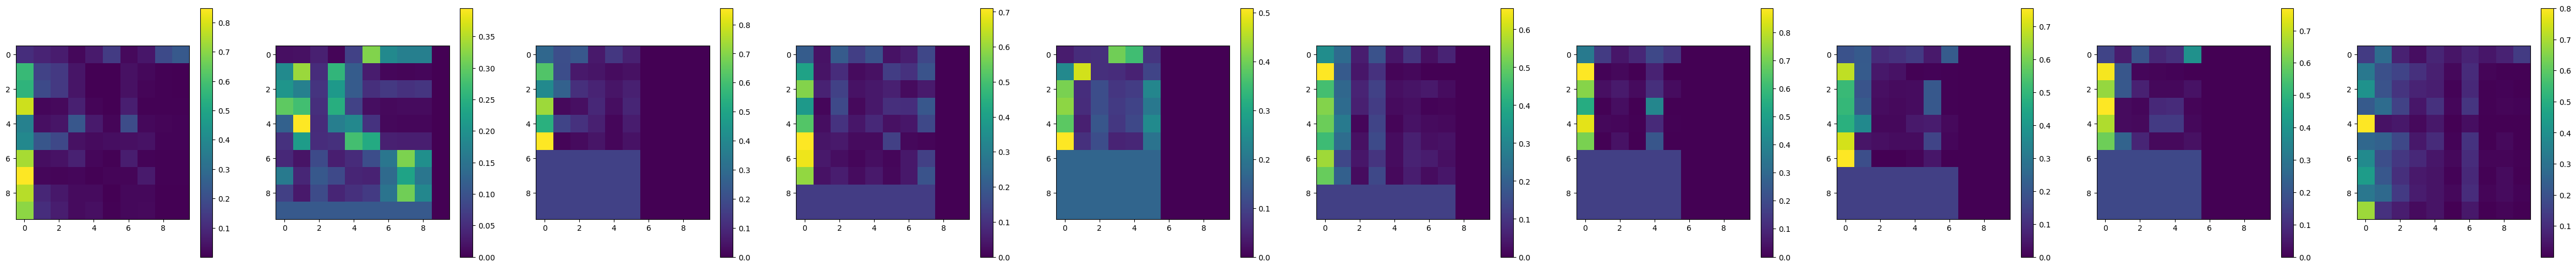

In [168]:
plotM(*att_weights_clcall[0:10], t=False)

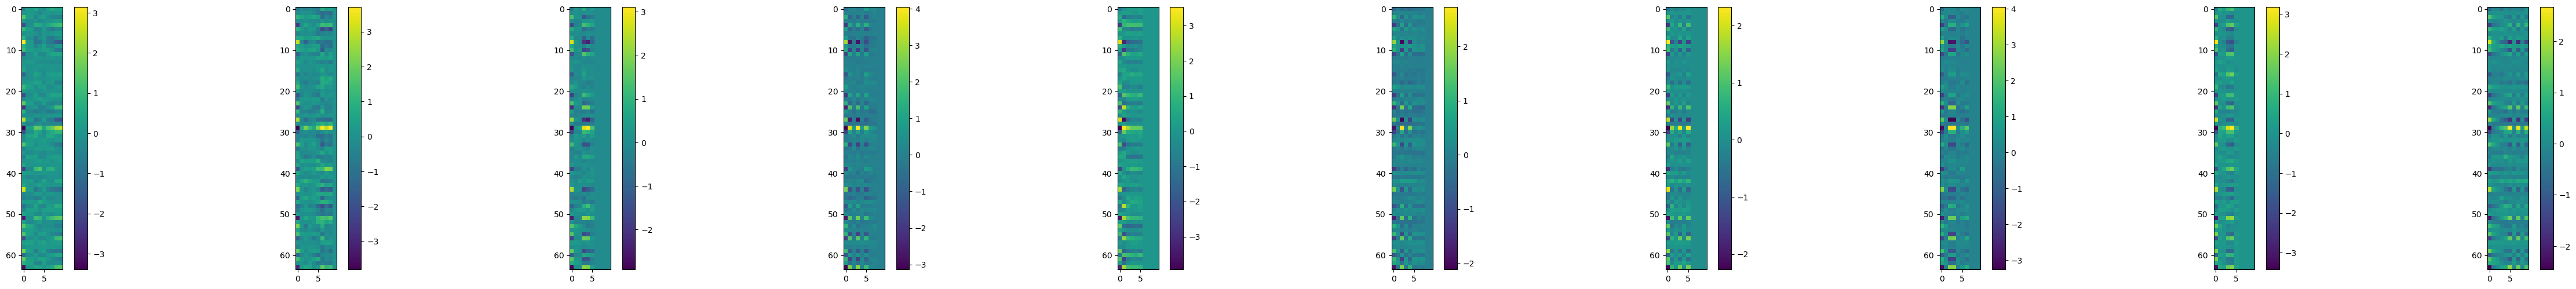

In [169]:
plotM(*out_SAcl[0:10])

In [176]:
tf.nn.sigmoid(dense_clclass)[9]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[1.0000000e+00],
       [9.9998105e-01],
       [9.9913752e-01],
       [9.2713726e-01],
       [5.6496447e-01],
       [5.8351981e-04],
       [9.7868365e-01],
       [7.7828887e-04],
       [2.1129254e-01],
       [1.9860533e-03]], dtype=float32)>

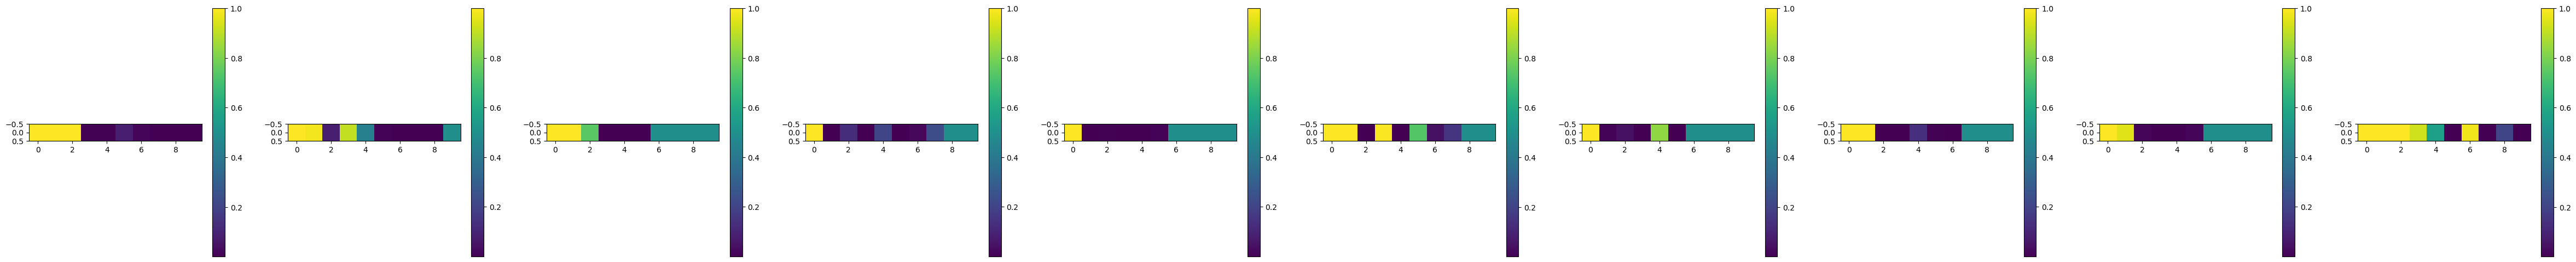

In [171]:
plotM(*tf.nn.sigmoid(dense_clclass)[0:10])

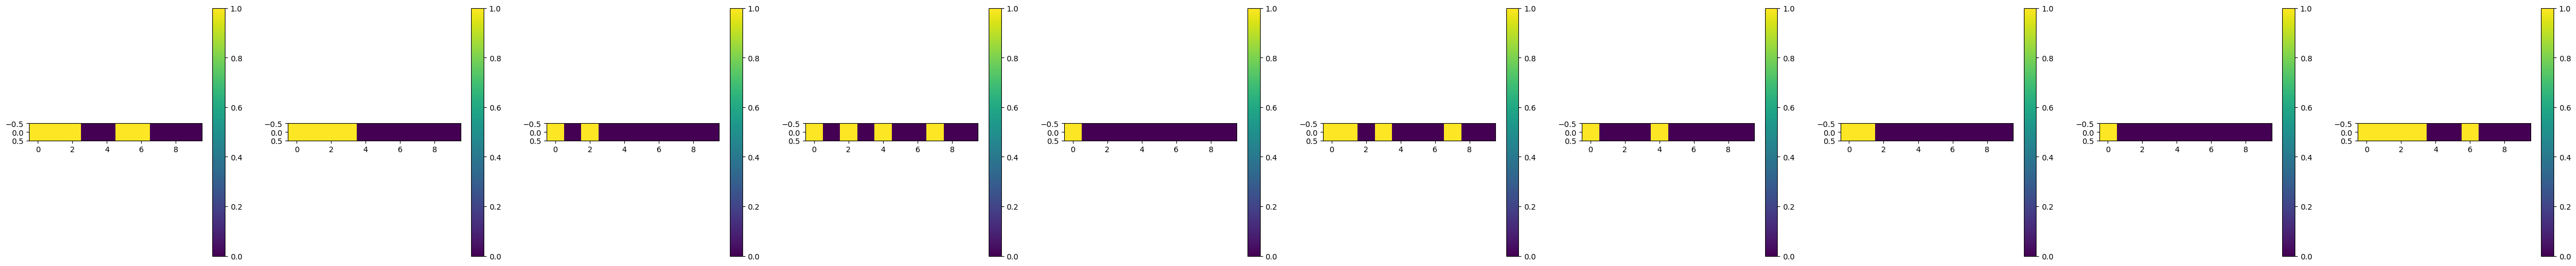

In [172]:
plotM(*y[0][0:10])

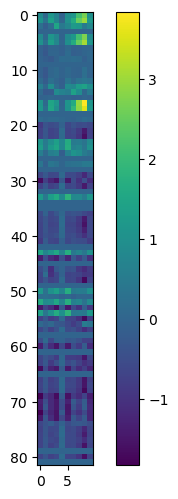

In [173]:
plotM(out_SAw[0:10])

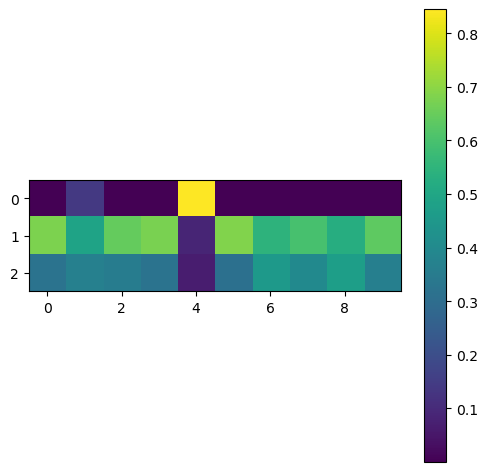

In [174]:
plotM(tf.nn.softmax(windclass[0:10]))

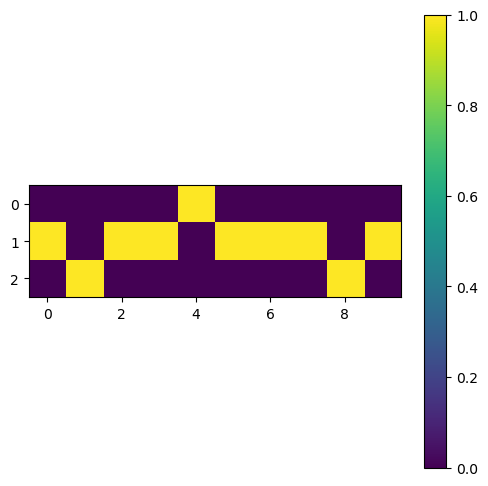

In [175]:
plotM(y[1][0:10])

# Test training

In [5]:
from model import *
from plotting import * 

- Ele training:  199254
- Gamma training:  299529
- Ele test:  38275
- Gamma test:  26130
- unmatched training:  758757
- unmatched testing:  84404

In [6]:
models_path = "/eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v5/"

#rain_steps_per_epoch = 
#eval_steps_per_epoch = 3e5 // batch_size
from collections import namedtuple
# Args = namedtuple('args', [ 'models_path', 'load','nepochs','ntrain','nval','nfeatures',
#                             'n_seed_features','batch_size','lr_decay','lr',
#                             'hidden_dim_input','hidden_dim_coord', 'hidden_dim_id',
#                             'n_layers_input', 'n_layers_id', 'n_layers_coord',
#                            'distance_dim','num_conv','dropout','convlayer',
#                            'nclass_labels', 'opt'])
Args = namedtuple('args', [ 'models_path', 'load','initial_epoch','nepochs','ntrain','nval',
                           'lr_decay','lr', 'batch_size','opt', 'activation', 
                           'output_dim_rechits', 'output_dim_nodes', 'output_dim_gconv', 'output_dim_sa_clclass',
                           'output_dim_sa_windclass','coord_dim','coord_dim_sa','nconv_rechits','nconv', 
                           'layers_input','layers_clclass','layers_windclass','n_windclasses',
                          'dropout','l2_reg','loss_clusters','loss_window','loss_softF1','loss_et_miss','loss_et_spur'])


args = Args( 
models_path = models_path,
load = False,
initial_epoch = 0,
nepochs = 100,
ntrain = 1000000,
nval = 200000,
lr_decay = 0.,
lr = 1e-3,
batch_size = 512,
opt='adam',
    
activation = tf.keras.activations.elu,
output_dim_rechits = 10,
output_dim_nodes = 64,
output_dim_gconv = 64,
output_dim_sa_clclass = 64,
output_dim_sa_windclass = 64,
coord_dim = 3,
coord_dim_sa = 12,
nconv_rechits = 3,
nconv = 3,
layers_input = [128,64,64],
layers_clclass = [64,64,32],
layers_windclass = [64,64,32],
n_windclasses = 3, 
dropout = 0.2,
l2_reg = True, 
    
loss_clusters= 1.,
loss_window= 1.2, 
loss_softF1= 1.5,
loss_et_miss= 6., 
loss_et_spur= 6.
)

### Dataset loading

In [7]:
def get_unique_run():
    previous_runs = os.listdir(args.models_path)
    if len(previous_runs) == 0:
        run_number = 1
    else:
        run_number = max([int(s.split('run_')[1]) for s in previous_runs]) + 1
    return run_number


if not os.path.isdir(args.models_path):
    os.makedirs(args.models_path)

name =  'run_{:02}'.format(get_unique_run())

outdir = args.models_path + name

if os.path.isdir(outdir):
    print("Output directory exists: {}".format(outdir), file=sys.stderr)
else:
    os.makedirs(outdir)

print(outdir)

/eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v5/run_05


In [8]:
data_path_train = {"ele_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v8/training/calo_matched/*.proto",
                  "gamma_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v8/training/calo_matched/*.proto",
                  "nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v8/training/no_calo_matched/*.proto",
                  #"gamma_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/no_calo_matched/*.proto"
                  }
data_path_test = {"ele_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v8/testing/calo_matched/*.proto",
                  "gamma_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v8/testing/calo_matched/*.proto",
                   "nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v8/testing/no_calo_matched/*.proto",
                  #"gamma_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/testing/no_calo_matched/*.proto"
                  }

In [9]:
features = [ "en_cluster","et_cluster",
            "cluster_eta", "cluster_phi", 
            "cluster_ieta","cluster_iphi","cluster_iz",
            "cluster_deta", "cluster_dphi",
            "cluster_den_seed","cluster_det_seed",
            "cl_f5_r9", "cl_f5_sigmaIetaIeta", "cl_f5_sigmaIetaIphi",
            "cl_f5_sigmaIphiIphi","cl_f5_swissCross",
            "cl_r9", "cl_sigmaIetaIeta", "cl_sigmaIetaIphi",
            "cl_sigmaIphiIphi","cl_swissCross",
            "cl_nxtals", "cl_etaWidth","cl_phiWidth"]

window_features = [  "max_en_cluster","max_et_cluster","max_deta_cluster","max_dphi_cluster","max_den_cluster","max_det_cluster",
                         "min_en_cluster","min_et_cluster","min_deta_cluster","min_dphi_cluster","min_den_cluster","min_det_cluster",
                         "mean_en_cluster","mean_et_cluster","mean_deta_cluster","mean_dphi_cluster","mean_den_cluster","mean_det_cluster" ]

# Metadata about the window like true energy, true calo position, useful info
window_metadata = ["en_true_sim","et_true_sim", "en_true_gen", "et_true_gen",
                    "nclusters_insc",
                    "nVtx", "rho", "obsPU", "truePU",
                    "sim_true_eta", "sim_true_phi",  
                    "en_mustache_raw", "et_mustache_raw","en_mustache_calib", "et_mustache_calib",
                    "event_tot_simen_PU","wtot_simen_PU","wtot_recoen_PU","wtot_simen_sig" ]
    
    

In [12]:
# Load a balanced dataset from the list of paths given to the function. Selected only the requestes features from clusters and prepare batches
train_ds = tf_data.load_balanced_dataset_batch(data_path_train, features, window_features, window_metadata, args.batch_size,weights={"ele_match":0.35,"gamma_match":0.35, "nomatch":0.3} )#weights={"ele_match":0.4,"gamma_match":0.4}
# the indexes for energy and et are from the features list we requestes
# train_ds = tf_data.delta_energy_seed(train_ds, en_index=0, et_index=1)
train_ds = tf_data.normalize_features(train_ds, "normalization.npz", "normalization_wind_features.npz")
train_ds = tf_data.training_format(train_ds)


test_ds = tf_data.load_balanced_dataset_batch(data_path_test, features, window_features, window_metadata, args.batch_size,weights={"ele_match":0.35,"gamma_match":0.35, "nomatch":0.3})
# the indexes for energy and et are from the features list we requestes
# test_ds = tf_data.delta_energy_seed(test_ds, en_index=0, et_index=1)
test_ds = tf_data.normalize_features(test_ds, "normalization.npz", "normalization_wind_features.npz")
test_ds = tf_data.training_format(test_ds)

# Create training and validation
ds_train = train_ds.prefetch(300).take(args.ntrain // args.batch_size).repeat(args.nepochs)
ds_test  = test_ds.prefetch(300).take(args.nval // args.batch_size).repeat(args.nepochs)

In [143]:
def filter(d1,d2):
    return  d1["s_f"][0] > 1.4 and  d1["s_f"][0] < 1.8 and d1["n_cl"] > 5 #and d1["s_f"][0] > 1.5 and d1["s_f"][0] < 2.2 and  d1["s_f"][6] < 50

special_ds = tf_data.load_balanced_dataset_batch(data_path_test, features, window_features, window_metadata,  20,filter=filter, weights={"ele_match":0.45,"gamma_match":0.45, "nomatch":0.1})
# the indexes for energy and et are from the features list we requestes
# special_ds = tf_data.delta_energy_seed(special_ds, en_index=0, et_index=1)
special_ds = tf_data.normalize_features(special_ds, "normalization.npz","normalization_wind_features.npz")
special_ds = tf_data.training_format(special_ds)

In [13]:
if args.lr_decay > 0:
        #lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        #    args.lr,
        #    decay_steps=int(args.ntrain//args.batch_size),
        #    decay_rate=args.lr_decay
        #)
        lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
            args.lr,
            decay_steps=int(args.ntrain//args.batch_size),
            decay_rate=args.lr_decay,
            staircase=True
        )
else:
    lr_schedule = args.lr


In [14]:
def get_model(args, weights=None):

    loss_weights = {"clusters":args.loss_clusters, "window":args.loss_window, 
                    "softF1":args.loss_softF1, "et_miss":args.loss_et_miss, "et_spur":args.loss_et_spur}
    tf.keras.backend.clear_session()

    
    with strategy.scope():
        opt = tf.keras.optimizers.Adam(learning_rate=args.lr)
        # Construction of the model
        model = DeepClusterGN(
                    activation = args.activation,
                    output_dim_rechits = args.output_dim_rechits,
                    output_dim_nodes =args.output_dim_nodes,
                    output_dim_gconv = args.output_dim_gconv,
                    output_dim_sa_clclass = args.output_dim_sa_clclass,
                    output_dim_sa_windclass = args.output_dim_sa_windclass,
                    coord_dim = args.coord_dim,
                    coord_dim_sa = args.coord_dim_sa,
                    nconv_rechits = args.nconv_rechits,
                    nconv = args.nconv,
                    layers_input = args.layers_input,
                    layers_clclass = args.layers_clclass,
                    layers_windclass = args.layers_windclass,
                    n_windclasses = args.n_windclasses,
                    dropout = args.dropout,
                    l2_reg = args.l2_reg,
                    loss_weights= loss_weights
                    )


        model.compile(optimizer=args.opt)
    #         metrics=[Precision(),Recall(), energy_resolution|_insc,energy_resolution_outsc,
    #                      energy_resolution_insc_log,energy_resolution_outsc_log,])
        model.set_metrics()

        for X, y in ds_train:
            ypred = model(X)
            #l = custom_loss(y, ypred)
            break
        
        if weights:
            model.load_weights(weights)
        
        return model

In [15]:
model = get_model(args)

In [16]:
model.summary()

Model: "deep_cluster_gn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
graph_builder (GraphBuilding multiple                  24025     
_________________________________________________________________
GHN_global (GHConvI)         multiple                  8256      
_________________________________________________________________
SA_clclass (SelfAttentionBlo multiple                  24960     
_________________________________________________________________
dense_clclass (Sequential)   (512, 19, 1)              14529     
_________________________________________________________________
SA_windclass (SelfAttentionB multiple                  41344     
_________________________________________________________________
dense_windclass (Sequential) (512, 3)                  11651     
_________________________________________________________________
dropout_18 (Dropout)         multiple              

In [18]:
callbacks = []
tb = tf.keras.callbacks.TensorBoard(
    log_dir=outdir, histogram_freq=2, 
    write_graph=False, 
    write_images=True,
    update_freq='epoch',
    profile_batch=0,
)
tb.set_model(model)
callbacks += [tb]

terminate_cb = tf.keras.callbacks.TerminateOnNaN()
callbacks += [terminate_cb]

lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1,
    mode='auto', min_delta=0.002, cooldown=0, min_lr=1e-7,
)


cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=outdir + "/weights.{epoch:02d}-{val_loss:.6f}.hdf5",
    save_weights_only=True,
    verbose=1
)
cp_callback.set_model(model)


early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.001, patience=10, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False
)
early.set_model(model)



callbacks += [cp_callback, lr_reduce, early]



In [19]:
if args.load:
    #ensure model input size is known
    for X, y in ds_train:
        model(X)
        break

    model.load_weights(args.load)
    
if args.nepochs > 0:
    ret = model.fit(ds_train,
        validation_data=ds_test, 
        epochs=args.nepochs,
        steps_per_epoch=args.ntrain//args.batch_size, 
        validation_steps=args.nval//args.batch_size,
        verbose=True,
        callbacks = callbacks,
        initial_epoch = args.initial_epoch
    )

Epoch 1/100
1953/1953 [==============================] - ETA: 0s - loss: 4.7608 - loss_clusters: 0.8645 - loss_windows: 0.6666 - loss_softF1: 0.7388 - loss_et_miss: 0.1375 - loss_et_spur: 0.1119
Epoch 00001: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v5/run_05/weights.01-3.579864.hdf5
1953/1953 [==============================] - 312s 160ms/step - loss: 4.7608 - loss_clusters: 0.8645 - loss_windows: 0.6666 - loss_softF1: 0.7388 - loss_et_miss: 0.1375 - loss_et_spur: 0.1119 - val_loss: 3.5799 - val_loss_clusters: 0.5959 - val_loss_windows: 0.6099 - val_loss_softF1: 0.7303 - val_loss_et_miss: 0.0723 - val_loss_et_spur: 0.0587
Epoch 2/100
1953/1953 [==============================] - ETA: 0s - loss: 3.6264 - loss_clusters: 0.6105 - loss_windows: 0.6253 - loss_softF1: 0.7321 - loss_et_miss: 0.0775 - loss_et_spur: 0.0671
Epoch 00002: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v5

Epoch 13/100
1953/1953 [==============================] - ETA: 0s - loss: 3.1425 - loss_clusters: 0.5131 - loss_windows: 0.5912 - loss_softF1: 0.7303 - loss_et_miss: 0.0634 - loss_et_spur: 0.0587
Epoch 00013: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v5/run_05/weights.13-3.030031.hdf5
1953/1953 [==============================] - 273s 140ms/step - loss: 3.1425 - loss_clusters: 0.5131 - loss_windows: 0.5912 - loss_softF1: 0.7303 - loss_et_miss: 0.0634 - loss_et_spur: 0.0587 - val_loss: 3.0300 - val_loss_clusters: 0.4782 - val_loss_windows: 0.5797 - val_loss_softF1: 0.7282 - val_loss_et_miss: 0.0598 - val_loss_et_spur: 0.0527
Epoch 14/100
1953/1953 [==============================] - ETA: 0s - loss: 3.1185 - loss_clusters: 0.5085 - loss_windows: 0.5898 - loss_softF1: 0.7301 - loss_et_miss: 0.0626 - loss_et_spur: 0.0580
Epoch 00014: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_

Epoch 25/100
1953/1953 [==============================] - ETA: 0s - loss: 3.0380 - loss_clusters: 0.4903 - loss_windows: 0.5836 - loss_softF1: 0.7289 - loss_et_miss: 0.0601 - loss_et_spur: 0.0562
Epoch 00025: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v5/run_05/weights.25-2.963301.hdf5
1953/1953 [==============================] - 273s 140ms/step - loss: 3.0380 - loss_clusters: 0.4903 - loss_windows: 0.5836 - loss_softF1: 0.7289 - loss_et_miss: 0.0601 - loss_et_spur: 0.0562 - val_loss: 2.9633 - val_loss_clusters: 0.4680 - val_loss_windows: 0.5739 - val_loss_softF1: 0.7287 - val_loss_et_miss: 0.0540 - val_loss_et_spur: 0.0556
Epoch 26/100
1953/1953 [==============================] - ETA: 0s - loss: 3.0355 - loss_clusters: 0.4903 - loss_windows: 0.5828 - loss_softF1: 0.7291 - loss_et_miss: 0.0600 - loss_et_spur: 0.0563
Epoch 00026: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_

Epoch 37/100
1953/1953 [==============================] - ETA: 0s - loss: 3.0007 - loss_clusters: 0.4815 - loss_windows: 0.5797 - loss_softF1: 0.7287 - loss_et_miss: 0.0589 - loss_et_spur: 0.0552
Epoch 00037: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v5/run_05/weights.37-2.922443.hdf5
1953/1953 [==============================] - 271s 139ms/step - loss: 3.0007 - loss_clusters: 0.4815 - loss_windows: 0.5797 - loss_softF1: 0.7287 - loss_et_miss: 0.0589 - loss_et_spur: 0.0552 - val_loss: 2.9224 - val_loss_clusters: 0.4658 - val_loss_windows: 0.5706 - val_loss_softF1: 0.7292 - val_loss_et_miss: 0.0562 - val_loss_et_spur: 0.0492
Epoch 38/100
1953/1953 [==============================] - ETA: 0s - loss: 2.9994 - loss_clusters: 0.4803 - loss_windows: 0.5802 - loss_softF1: 0.7291 - loss_et_miss: 0.0587 - loss_et_spur: 0.0553
Epoch 00038: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_

Epoch 49/100
1953/1953 [==============================] - ETA: 0s - loss: 2.9897 - loss_clusters: 0.4778 - loss_windows: 0.5790 - loss_softF1: 0.7294 - loss_et_miss: 0.0582 - loss_et_spur: 0.0550
Epoch 00049: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v5/run_05/weights.49-2.907458.hdf5
1953/1953 [==============================] - 273s 140ms/step - loss: 2.9897 - loss_clusters: 0.4778 - loss_windows: 0.5790 - loss_softF1: 0.7294 - loss_et_miss: 0.0582 - loss_et_spur: 0.0550 - val_loss: 2.9075 - val_loss_clusters: 0.4560 - val_loss_windows: 0.5707 - val_loss_softF1: 0.7264 - val_loss_et_miss: 0.0538 - val_loss_et_spur: 0.0518
Epoch 50/100
1953/1953 [==============================] - ETA: 0s - loss: 2.9881 - loss_clusters: 0.4778 - loss_windows: 0.5785 - loss_softF1: 0.7295 - loss_et_miss: 0.0582 - loss_et_spur: 0.0548
Epoch 00050: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_

In [177]:
import mplhep as hep
plt.style.use(hep.style.CMS)

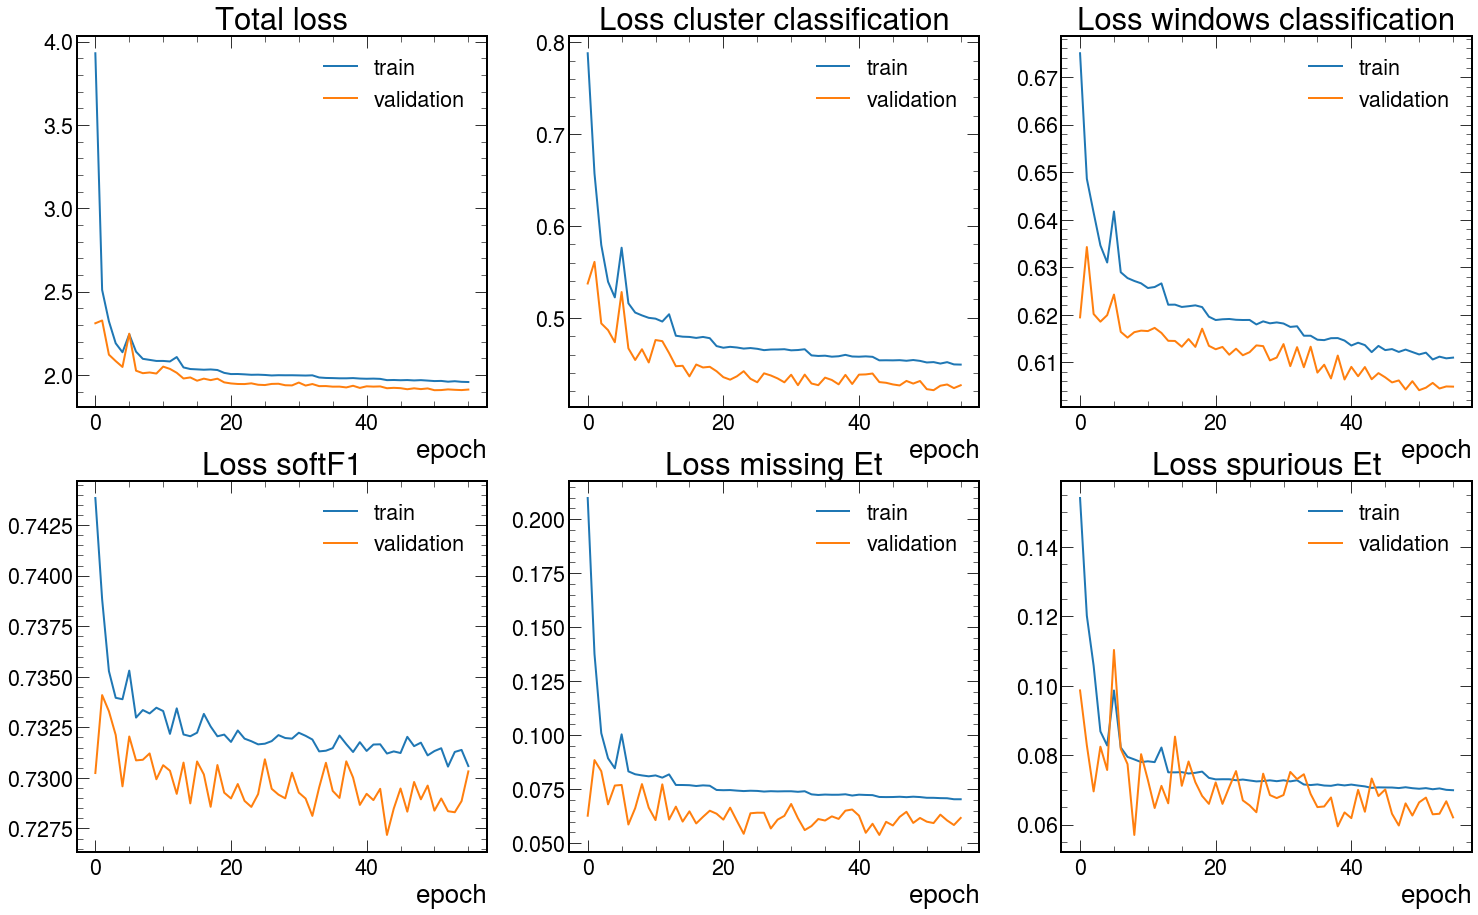

In [81]:
f, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(25, 15))

ax1.plot(ret.history["loss"], label="train", linewidth=2)
ax1.plot(ret.history["val_loss"],label="validation", linewidth=2)
ax1.set_title("Total loss")
ax1.set_xlabel("epoch")
ax1.legend()

ax2.plot(ret.history["loss_clusters"], label="train", linewidth=2)
ax2.plot(ret.history["val_loss_clusters"],label="validation", linewidth=2)
ax2.set_title("Loss cluster classification")
ax2.set_xlabel("epoch")
ax2.legend()

ax3.plot(ret.history["loss_windows"], label="train", linewidth=2)
ax3.plot(ret.history["val_loss_windows"],label="validation", linewidth=2)
ax3.set_title("Loss windows classification")
ax3.set_xlabel("epoch")
ax3.legend()

ax4.plot(ret.history["loss_softF1"], label="train", linewidth=2)
ax4.plot(ret.history["val_loss_softF1"],label="validation", linewidth=2)
ax4.set_title("Loss softF1")
ax4.set_xlabel("epoch")
ax4.legend()

ax5.plot(ret.history["loss_et_miss"], label="train", linewidth=2)
ax5.plot(ret.history["val_loss_et_miss"],label="validation", linewidth=2)
ax5.set_title("Loss missing Et")
ax5.set_xlabel("epoch")
ax5.legend()

ax6.plot(ret.history["loss_et_spur"], label="train", linewidth=2)
ax6.plot(ret.history["val_loss_et_spur"],label="validation", linewidth=2)
ax6.set_title("Loss spurious Et")
ax6.set_xlabel("epoch")
ax6.legend()

f.savefig(outdir + "/train_loss.png")


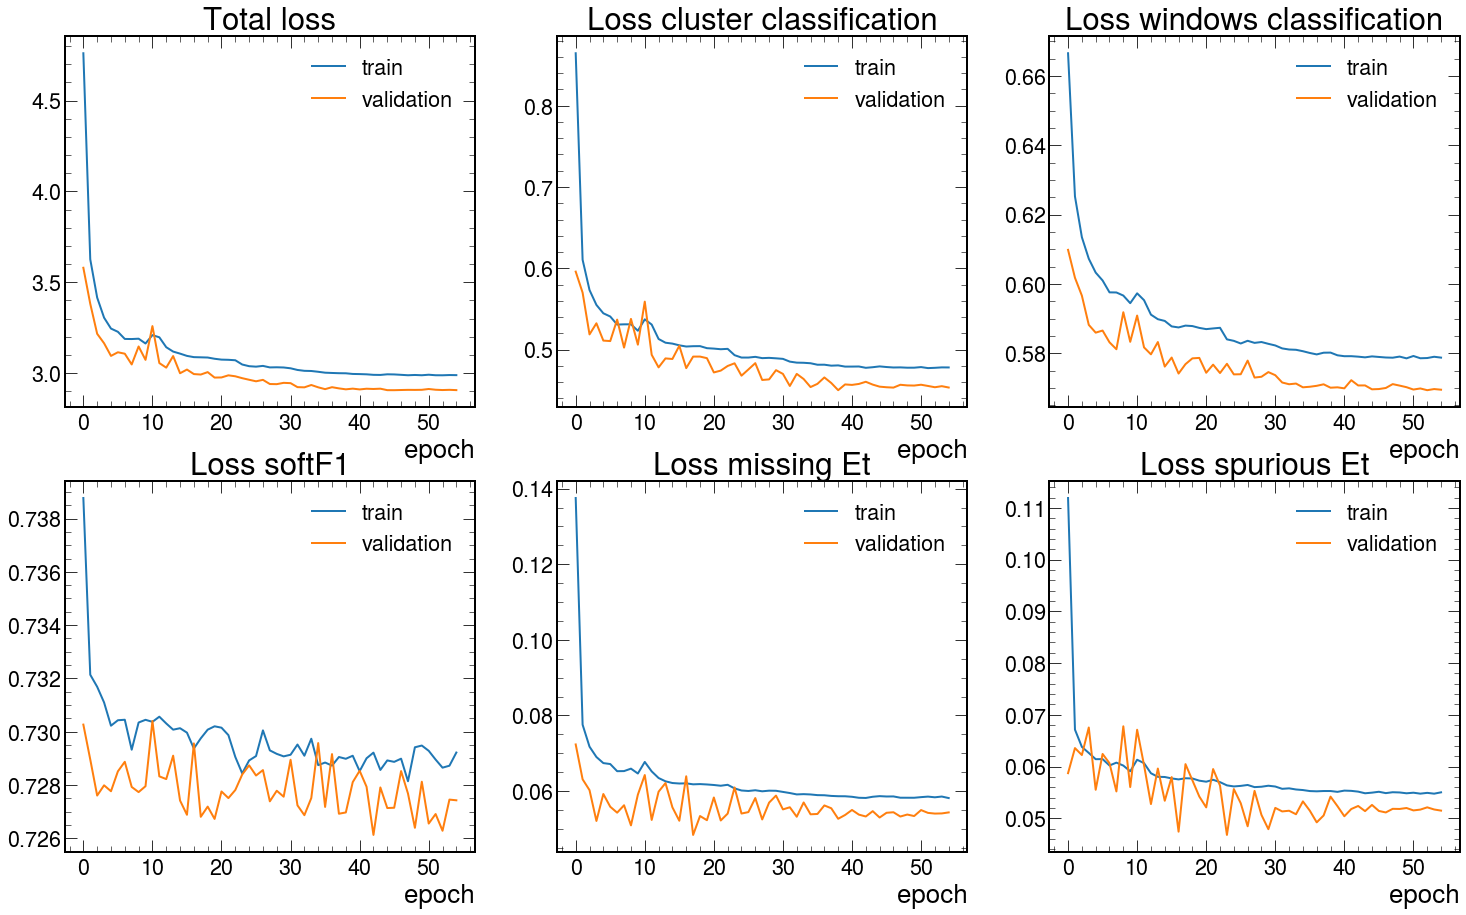

In [178]:
f, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(25, 15))

ax1.plot(ret.history["loss"], label="train", linewidth=2)
ax1.plot(ret.history["val_loss"],label="validation", linewidth=2)
ax1.set_title("Total loss")
ax1.set_xlabel("epoch")
ax1.legend()

ax2.plot(ret.history["loss_clusters"], label="train", linewidth=2)
ax2.plot(ret.history["val_loss_clusters"],label="validation", linewidth=2)
ax2.set_title("Loss cluster classification")
ax2.set_xlabel("epoch")
ax2.legend()

ax3.plot(ret.history["loss_windows"], label="train", linewidth=2)
ax3.plot(ret.history["val_loss_windows"],label="validation", linewidth=2)
ax3.set_title("Loss windows classification")
ax3.set_xlabel("epoch")
ax3.legend()

ax4.plot(ret.history["loss_softF1"], label="train", linewidth=2)
ax4.plot(ret.history["val_loss_softF1"],label="validation", linewidth=2)
ax4.set_title("Loss softF1")
ax4.set_xlabel("epoch")
ax4.legend()

ax5.plot(ret.history["loss_et_miss"], label="train", linewidth=2)
ax5.plot(ret.history["val_loss_et_miss"],label="validation", linewidth=2)
ax5.set_title("Loss missing Et")
ax5.set_xlabel("epoch")
ax5.legend()

ax6.plot(ret.history["loss_et_spur"], label="train", linewidth=2)
ax6.plot(ret.history["val_loss_et_spur"],label="validation", linewidth=2)
ax6.set_title("Loss spurious Et")
ax6.set_xlabel("epoch")
ax6.legend()

f.savefig(outdir + "/train_loss.png")


In [179]:
with open(outdir + "/args.txt",'w') as config:
    config.write(str(args))
    
#model.save(outdir+"/model")



In [190]:
configs

{'models_path': '/eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v5/',
 'nepochs': 100,
 'ntrain': 1000000,
 'nval': 200000,
 'lr_decay': 0.0,
 'lr': 0.001,
 'batch_size': 512,
 'opt': 'adam',
 'activation': <function tensorflow.python.keras.activations.elu(x, alpha=1.0)>,
 'output_dim_rechits': 10,
 'output_dim_nodes': 64,
 'output_dim_gconv': 64,
 'output_dim_sa_clclass': 64,
 'output_dim_sa_windclass': 64,
 'coord_dim': 3,
 'coord_dim_sa': 12,
 'nconv_rechits': 3,
 'nconv': 3,
 'layers_input': [128, 64, 64],
 'layers_clclass': [64, 64, 32],
 'layers_windclass': [64, 64, 32],
 'n_windclasses': 3,
 'dropout': 0.2,
 'l2_reg': True,
 'loss_clusters': 1.0,
 'loss_window': 1.2,
 'loss_softF1': 1.5,
 'loss_et_miss': 6.0,
 'loss_et_spur': 6.0}

In [191]:
conf = [ 'models_path', 'nepochs','ntrain','nval',
                           'lr_decay','lr', 'batch_size','opt', 'activation', 
                           'output_dim_rechits', 'output_dim_nodes', 'output_dim_gconv', 'output_dim_sa_clclass',
                           'output_dim_sa_windclass','coord_dim','coord_dim_sa','nconv_rechits','nconv', 
                           'layers_input','layers_clclass','layers_windclass','n_windclasses',
                          'dropout','l2_reg','loss_clusters','loss_window','loss_softF1','loss_et_miss','loss_et_spur']

configs = {}
for c in conf:
    if c == 'activation': configs[c] = "elu"
    else: configs[c] = getattr(args, c)
    
import json
json.dump(configs, open(outdir + "/args_load.json","w"), indent=2)

In [181]:
configs

{'models_path': '/eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v5/',
 'nepochs': 100,
 'ntrain': 1000000,
 'nval': 200000,
 'lr_decay': 0.0,
 'lr': 0.001,
 'batch_size': 512,
 'opt': 'adam',
 'activation': <function tensorflow.python.keras.activations.elu(x, alpha=1.0)>,
 'output_dim_rechits': 10,
 'output_dim_nodes': 64,
 'output_dim_gconv': 64,
 'output_dim_sa_clclass': 64,
 'output_dim_sa_windclass': 64,
 'coord_dim': 3,
 'coord_dim_sa': 12,
 'nconv_rechits': 3,
 'nconv': 3,
 'layers_input': [128, 64, 64],
 'layers_clclass': [64, 64, 32],
 'layers_windclass': [64, 64, 32],
 'n_windclasses': 3,
 'dropout': 0.2,
 'l2_reg': True,
 'loss_clusters': 1.0,
 'loss_window': 1.2,
 'loss_softF1': 1.5,
 'loss_et_miss': 6.0,
 'loss_et_spur': 6.0}

### Test loss

In [111]:
X,y_true= tf_data.get(ds_test)

In [112]:
y_pred = model(X)

In [117]:
dense_clclass,dense_windclass, mask_cls, _  = y_pred
y_clclass, y_windclass, cl_X, y_metadata = y_true
y_target = tf.cast(y_clclass, tf.float32) 

pred_prob = tf.nn.sigmoid(dense_clclass)
diff = tf.math.abs(y_target - pred_prob)
Et = cl_X[:,:,1:2]

missing_en = Et * diff * y_target
spurious_en =  Et * diff * (1 - y_target)

reduced_loss_missing = tf.reduce_mean(tf.reduce_sum(missing_en, axis=1)) 
reduced_loss_spurious =  tf.reduce_mean(tf.reduce_sum(spurious_en, axis=1))

In [160]:
dense_clclass,dense_windclass, mask_cls, _  = y_pred
y_clclass, y_windclass, cl_X, y_metadata = y_true
y_target = tf.cast(y_clclass, tf.float32) 

pred_prob = tf.nn.sigmoid(dense_clclass)

In [169]:
tp = pred_prob * y_target
fn = (1 - pred_prob) * y_target
fp = pred_prob * (1 - y_target)

In [182]:
tptot = tf.reduce_sum(tp, axis=1)
fntot = tf.reduce_sum(fn, axis=1)
fptot = tf.reduce_sum(fp, axis=1)

In [187]:
1 - (2 * tptot)/ (2*tptot + fntot + fptot + 1e-16) 

<tf.Tensor: shape=(128, 1), dtype=float32, numpy=
array([[0.8643937 ],
       [0.8417007 ],
       [0.7678521 ],
       [0.8621445 ],
       [0.8818361 ],
       [0.6749588 ],
       [0.86786455],
       [0.84230775],
       [0.8560391 ],
       [0.84797996],
       [0.8713441 ],
       [0.8565036 ],
       [0.87739176],
       [0.86709696],
       [0.855233  ],
       [0.86079264],
       [0.8512083 ],
       [0.86182773],
       [0.68536377],
       [0.8597818 ],
       [0.86351144],
       [0.863147  ],
       [0.85580873],
       [0.85421795],
       [0.87876534],
       [0.8604276 ],
       [0.86217374],
       [0.8579935 ],
       [0.86134374],
       [0.8482436 ],
       [0.8498958 ],
       [0.8549104 ],
       [0.8570379 ],
       [0.8734256 ],
       [0.8786647 ],
       [0.8799868 ],
       [0.8757078 ],
       [0.8537595 ],
       [0.8767978 ],
       [0.86964816],
       [0.8642583 ],
       [0.85530466],
       [0.86631775],
       [0.5863811 ],
       [0.85295665],
     

In [130]:
reduced_loss_spurious

<tf.Tensor: shape=(), dtype=float32, numpy=0.064462475>

### Layers inspection

In [192]:
model.layers

In [193]:
graphbuild = model.layers[0]

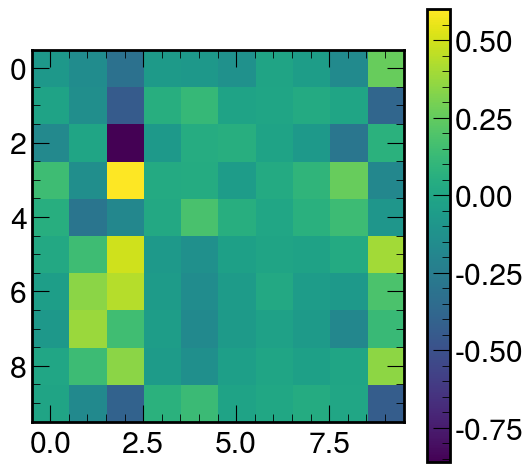

In [194]:
plotM(graphbuild.rechitsGCN.weights[2].numpy())